# ML Training Notebook

## Import dependencies

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_validate, train_test_split


from pathlib import Path
import datetime as dt
import pandas as pd
import csv
import json
import uuid

In [2]:
!pip install mord

In [3]:
import mord 

In [4]:
path = Path('../../spatial_cleaned_inspections.csv')
df = pd.read_csv(path)

df.drop(columns = ['camis', 'latitude', 'longitude'], inplace = True)

### Modeling Notes:

#### A few options on binning:

1. Regression on the raw score
    - What it does: Predicts the exact numeric score (0–100+).
    - Why it’s powerful: Uses the full continuum of the target, so you’re not discarding any nuance.
    - Trade‑off: You have to choose your pass/fail or A/B/C thresholds after you fit the model (but you can even tune those thresholds on a hold‑out set).

2. Ordinal‑aware multi‑class
    - What it does: Predicts ordered buckets (e.g. A/B/C → 0/1/2) while explicitly modeling their order.
    - Why it helps: You still collapse the score into 3 groups, but your loss function “knows” that mis‑predicting A→B is a smaller error than A→C. That extra structure often boosts classification performance versus treating classes as unrelated.

3. Plain multi‑class
    - What it does: Predicts A, B, or C as independent labels.
    - Why it’s weaker: Loses both granularity (all within‑class differences) and ordering information.

4. Binary (fail/pass)
    - What it does: Predicts whether score ≥ 28.
    - Why it’s simplest: Straightforward, but you throw out nearly all of the score’s information (e.g. you treat a 27 the same as a 0).

#### A starting pathway for choosing the target approach:

1. **Start simple with the binary flag**

   * Create

     ```python
     df['failing'] = (df.score >= 28).astype(int)
     ```
   * Train a classifier (e.g. logistic regression or random forest) and evaluate ROC‑AUC / F1 on “fail.”
   * You’ll get a baseline that directly answers “who fails?” with minimal fuss.

2. **If you need more insight, step up to ordinal**

   * Map scores into A/B/C:

     ```python
     bins = [ -1, 13, 27, float('inf') ]
     labels = ['A','B','C']
     df['grade'] = pd.cut(df.score, bins=bins, labels=labels)
     ```
   * Use an **ordinal** model (e.g. `statsmodels`’ OrdinalLogit) or transform into multiple binary tasks (cumulative link).
   * This lets you exploit the fact that mis‐classifying A→B is “less wrong” than A→C.

3. **Regression if you really care about exact scores**

   * Predict `score` directly, then choose your cutoff(s) in post‑processing.
   * You can even treat the cutoff as a hyperparameter and tune it on your validation set for best classification metrics.


##### Why not jump straight to multi‑class/ordinal?

* **Complexity**: True ordinal methods require special loss functions or libraries.
* **Data needs**: More classes mean fewer examples per class, which can hurt performance.
* **Interpretability**: Stakeholders often just want “pass/fail.”


##### How ordinal vs. numeric thresholding differ

* A **plain multi‑class tree** treats A, B, C as unrelated labels.  You’d need to encode order (e.g. A→0, B→1, C→2) and accept that your model is really doing regression on those integers.
* A **true ordinal** approach (cumulative link models, ordinal forest, etc.) explicitly penalizes “distance” between predicted and true classes in its loss.


**Bottom line:**

* **If your goal is simply “which restaurants fail?”**, go with the binary flag at 28.
* **If you want richer predictions on letter grade**, do the ordinal multi‑class next (but be aware you’ll need an ordinal‐aware method to fully exploit ordering).
* **If you care about exact score predictions (and may want different thresholds later)**, build a regression model and threshold afterward.

## Preprocessing

#### Classes To Help

In [5]:
class ML_Helper:
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
        self.target = 'score'

    def pass_fail_bins(self) -> pd.DataFrame:
        if self.target == 'score':    
            self.df['failing'] = (self.df[self.target] >= 28).astype(int)
            self.df.drop(columns = self.target, inplace = True)
            self.target = 'failing'
            return self
        else:
            print('Could not finish. Please ensure .ordinal_bins() has not already be run.')

    def ordinal_bins(self) -> pd.DataFrame:
        if self.target == 'score':
            bins = [-1, 13, 27, float('inf')]
            labels = [0, 1, 2]  # A=0, B=1, C=2
            self.df['grade'] = pd.cut(self.df[self.target], bins = bins, labels = labels).astype(int)
            self.df.drop(columns = [self.target], inplace = True)
            self.target = 'grade'
            return self
        else:
            print('Could not finish. Please ensure .pass_fail_bins() has not already be run.')

    def target_split(self) -> tuple[pd.DataFrame, pd.Series]:
        return self.df.drop(columns = [self.target]), self.df[self.target]


class Log_Training:
    '''
        Logs experiments to a per-user CSV. Each row contains:
        - timestamp (ISO)
        - run_id (UUID4)
        - model_name (class name)
        - params (JSON dict)
        - metrics (JSON dict)
        - extra (JSON dict for anything else you want to track)
    '''

    def __init__(self, classmate_name: str, log_dir = Path('logs')):
        self.classmate = classmate_name
        log_dir.mkdir(exist_ok = True)
        log_stem = f'{classmate_name}_models.csv'
        self.log_path = log_dir / log_stem

        # If the file doesn’t exist, write a header
        # if not os.path.isfile(self.log_path):
        if not self.log_path.is_file():
            with open(self.log_path, 'w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(['timestamp','run_id','model_name','params','metrics','extra'])

    def log(self,
            model=None,
            *,
            model_name: str = None,
            params: dict = None,
            metrics: dict = None,
            extra: dict = None
        ):
        '''
        Write one experiment record.
        If you pass a scikit‑learn–style `model`, its .get_params() will be recorded automatically.
        Otherwise, supply model_name and params explicitly.
        '''
        # Determine the name
        name = model_name or (model.__class__.__name__ if model is not None else '<unknown>')

        # Get params
        if params is None:
            if model is not None and hasattr(model, 'get_params'):
                params = getattr(model, 'get_params')
            else:
                try:
                    params = getattr(model, '__dict__', {})
                except:
                    params = {}
        # Default metrics/extra
        metrics = metrics or {}
        extra   = extra   or {}
        row = [
            dt.datetime.now(dt.UTC).isoformat(),
            str(uuid.uuid4()),
            name,
            json.dumps(params,  separators=('',','':'), default=str),
            json.dumps(metrics, separators=(',',':'), default=str),
            json.dumps(extra,   separators=(',',':'), default=str),
        ]

        with open(self.log_path, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(row)

        return None

    def train_and_log_mord(self, X, y, test_size, **mord_kwargs):
        Xtr, Xte, ytr, yte = train_test_split(X, y, test_size = test_size, stratify = y)
        m = mord.LogisticIT(**mord_kwargs).fit(Xtr, ytr)
        preds = m.predict(Xte)
        metrics = {'accuracy': accuracy_score(yte, preds)}
        self.log(model=m, metrics=metrics)
        return print(metrics)

#### Using ML_Helper

- Pass in a df to the constructor and save it to a variable of your choice: `ml = ML_Helper(df)`  

- Call either `ml.pass_fail_bins()` or `ml.ordinal_bins()`, or neither for full score regression. You cannot call both, it won't work.  
    + This step is to take our target variable (which is the inspection score) and either convert it to a pass fail, or to the letter grade  

- Lastly, call `X, y = ml.target_split()` to get an automatic split of the X and y variables.

### Run Trainings Here!

In [6]:
# Binary Model

helper = ML_Helper(df)
helper.pass_fail_bins()
X, y = helper.target_split()

print (f"Binary target distribution: {y.value_counts()}")

print('0 = Pass \n1 = Fail')

Binary target distribution: failing
0    178786
1     85979
Name: count, dtype: int64
0 = Pass 
1 = Fail


In [7]:
X.head(20)


,boro,zipcode,cuisine,inspection_date,inspection_type,inspection_subtype,action,violation_code,critical_flag,census_tract,nta
0,Queens,11354,Korean,2023-11-27,Cycle Inspection,Initial Inspection,cited_violation,04M,Critical,87100,QN22
1,Brooklyn,11220,Bakery Products/Desserts,2023-08-17,Cycle Inspection,Initial Inspection,cited_violation,02B,Critical,10400,BK34
2,Queens,11378,American,2023-04-11,Cycle Inspection,Initial Inspection,cited_violation,06D,Critical,51500,QN30
3,Bronx,10453,Chicken,2024-11-07,Cycle Inspection,Initial Inspection,cited_violation,04M,Critical,21501,BX36
4,Brooklyn,11231,Thai,2023-03-09,Cycle Inspection,Initial Inspection,cited_violation,02B,Critical,7500,BK33
5,Manhattan,10013,Japanese,2022-05-19,Cycle Inspection,Re-inspection,cited_violation,02G,Critical,4100,MN24
6,Queens,11373,Coffee/Tea,2024-10-28,Cycle Inspection,Initial Inspection,cited_violation,10H,Not Critical,47300,QN29
7,Brooklyn,11231,American,2022-09-09,Cycle Inspection,Re-inspection,cited_violation,04H,Critical,7700,BK33
8,Manhattan,10022,Japanese,2022-11-28,Cycle Inspection,Initial Inspection,cited_violation,08A,Not Critical,9800,MN19
9,Manhattan,10036,Irish,2023-12-12,Cycle Inspection,Initial Inspection,cited_violation,02B,Critical,9600,MN17


In [8]:
X.shape


(264765, 11)

In [9]:
X['census_tract'].value_counts().describe()

count    1175.000000
mean      225.331915
std       316.041719
min         2.000000
25%        45.500000
50%       112.000000
75%       249.000000
max      2465.000000
Name: count, dtype: float64

In [10]:
X['census_tract'].value_counts(normalize=True).head(40)

census_tract
87100    0.009310
6500     0.008517
2900     0.007735
2100     0.007618
4100     0.007218
700      0.006953
3800     0.006674
7600     0.006659
900      0.006496
3300     0.006307
10400    0.006092
12100    0.005968
1800     0.005737
11300    0.005730
4300     0.005647
9200     0.005643
9600     0.005624
13700    0.005571
6800     0.005480
8400     0.005473
6700     0.005461
9800     0.005314
13100    0.005114
11900    0.005095
6300     0.005065
5800     0.004921
10000    0.004876
7400     0.004834
11500    0.004680
15700    0.004532
6100     0.004408
13300    0.004340
7700     0.004317
3200     0.004162
10100    0.004090
1900     0.004083
85300    0.003977
4000     0.003973
3400     0.003928
12500    0.003917
Name: proportion, dtype: float64

In [11]:
X['census_tract'].nunique()

1175

In [12]:
census_tract_count = X['census_tract'].value_counts()
rare_census_tracts = census_tract_count[census_tract_count < 200].index
X['census_tract'] = X['census_tract'].replace(rare_census_tracts, 'rare census tract')


In [13]:
X.nunique()

boro                     5
zipcode                218
cuisine                 89
inspection_date       1476
inspection_type          9
inspection_subtype       6
action                   5
violation_code         123
critical_flag            3
census_tract           361
nta                    193
dtype: int64

In [14]:
X['cuisine'].value_counts().head(40)

cuisine
American                          42072
Chinese                           26325
Coffee/Tea                        18580
Pizza                             16315
Latin American                    11454
Mexican                           10799
Bakery Products/Desserts          10686
Caribbean                          9695
Japanese                           9176
Italian                            8830
Chicken                            7045
Spanish                            6879
Asian/Asian Fusion                 5256
Donuts                             4841
Sandwiches                         4827
Juice, Smoothies, Fruit Salads     4697
Indian                             4397
Thai                               4199
Hamburgers                         4067
Korean                             3940
Jewish/Kosher                      3907
Mediterranean                      3312
Other                              3072
Tex-Mex                            3030
Frozen Desserts                 

In [15]:
X['cuisine'].value_counts(normalize = True).head(40)

cuisine
American                          0.158903
Chinese                           0.099428
Coffee/Tea                        0.070175
Pizza                             0.061621
Latin American                    0.043261
Mexican                           0.040787
Bakery Products/Desserts          0.040360
Caribbean                         0.036617
Japanese                          0.034657
Italian                           0.033350
Chicken                           0.026609
Spanish                           0.025982
Asian/Asian Fusion                0.019852
Donuts                            0.018284
Sandwiches                        0.018231
Juice, Smoothies, Fruit Salads    0.017740
Indian                            0.016607
Thai                              0.015859
Hamburgers                        0.015361
Korean                            0.014881
Jewish/Kosher                     0.014756
Mediterranean                     0.012509
Other                             0.011603
Tex

In [16]:
X['cuisine'].value_counts().describe()

count       89.00000
mean      2974.88764
std       6091.76646
min          2.00000
25%        134.00000
50%        576.00000
75%       3072.00000
max      42072.00000
Name: count, dtype: float64

In [17]:
cuisine_counts = X['cuisine'].value_counts()

rare_cuisine = cuisine_counts[cuisine_counts < 200].index
X['cuisine'] = X['cuisine'].replace(rare_cuisine, 'rare cuisine')

In [18]:
X['inspection_date'] = pd.to_datetime(X['inspection_date'])

In [19]:
X['inspection_month'] = X['inspection_date'].dt.month

In [20]:
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

X['inspection_season'] = X['inspection_month'].apply(month_to_season)



In [21]:
X.columns

Index(['boro', 'zipcode', 'cuisine', 'inspection_date', 'inspection_type',
       'inspection_subtype', 'action', 'violation_code', 'critical_flag',
       'census_tract', 'nta', 'inspection_month', 'inspection_season'],
      dtype='object')

In [22]:
X.head()

,boro,zipcode,cuisine,inspection_date,inspection_type,inspection_subtype,action,violation_code,critical_flag,census_tract,nta,inspection_month,inspection_season
0,Queens,11354,Korean,2023-11-27,Cycle Inspection,Initial Inspection,cited_violation,04M,Critical,87100,QN22,11,Fall
1,Brooklyn,11220,Bakery Products/Desserts,2023-08-17,Cycle Inspection,Initial Inspection,cited_violation,02B,Critical,10400,BK34,8,Summer
2,Queens,11378,American,2023-04-11,Cycle Inspection,Initial Inspection,cited_violation,06D,Critical,rare census tract,QN30,4,Spring
3,Bronx,10453,Chicken,2024-11-07,Cycle Inspection,Initial Inspection,cited_violation,04M,Critical,rare census tract,BX36,11,Fall
4,Brooklyn,11231,Thai,2023-03-09,Cycle Inspection,Initial Inspection,cited_violation,02B,Critical,7500,BK33,3,Spring


In [23]:
X['inspection_date'].dtype

dtype('<M8[ns]')

In [24]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264765 entries, 0 to 264764
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   boro                264765 non-null  object        
 1   zipcode             264765 non-null  int64         
 2   cuisine             264765 non-null  object        
 3   inspection_date     264765 non-null  datetime64[ns]
 4   inspection_type     264765 non-null  object        
 5   inspection_subtype  264765 non-null  object        
 6   action              264765 non-null  object        
 7   violation_code      263074 non-null  object        
 8   critical_flag       264765 non-null  object        
 9   census_tract        264765 non-null  object        
 10  nta                 264765 non-null  object        
 11  inspection_month    264765 non-null  int32         
 12  inspection_season   264765 non-null  object        
dtypes: datetime64[ns](1), int32(1

In [25]:
inspection_date = X['inspection_date'].dt


In [26]:
X = X.drop(columns = ["inspection_date"])


In [27]:
X.head()

,boro,zipcode,cuisine,inspection_type,inspection_subtype,action,violation_code,critical_flag,census_tract,nta,inspection_month,inspection_season
0,Queens,11354,Korean,Cycle Inspection,Initial Inspection,cited_violation,04M,Critical,87100,QN22,11,Fall
1,Brooklyn,11220,Bakery Products/Desserts,Cycle Inspection,Initial Inspection,cited_violation,02B,Critical,10400,BK34,8,Summer
2,Queens,11378,American,Cycle Inspection,Initial Inspection,cited_violation,06D,Critical,rare census tract,QN30,4,Spring
3,Bronx,10453,Chicken,Cycle Inspection,Initial Inspection,cited_violation,04M,Critical,rare census tract,BX36,11,Fall
4,Brooklyn,11231,Thai,Cycle Inspection,Initial Inspection,cited_violation,02B,Critical,7500,BK33,3,Spring


In [28]:
# Encoding categorical variables for processing. 
# We combine X and Y temporarily to for clean transformation. 

new_df = pd.concat([X, y], axis = 1)

# Define categorical columns
categorical_columns = ['boro', 'cuisine', 'inspection_type', 'inspection_subtype',
                    'action', 'violation_code', 'critical_flag', 'census_tract', 'nta', 'inspection_month', 'inspection_season']

# Hot-encode categorical columns. 

df_encoded = pd.get_dummies(new_df, columns = categorical_columns, drop_first = True)

# Split the data back into target and features. 

X_encoded = df_encoded.drop(columns = ['failing'])
y_encoded = df_encoded['failing']

# Inspect data.

X_encoded.head()

,zipcode,boro_Brooklyn,boro_Manhattan,boro_Queens,boro_Staten Island,cuisine_American,cuisine_Asian/Asian Fusion,cuisine_Australian,cuisine_Bagels/Pretzels,cuisine_Bakery Products/Desserts,...,inspection_month_6,inspection_month_7,inspection_month_8,inspection_month_9,inspection_month_10,inspection_month_11,inspection_month_12,inspection_season_Spring,inspection_season_Summer,inspection_season_Winter
0,11354,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,11220,True,False,False,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,True,False
2,11378,False,False,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,10453,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,11231,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [29]:
# Split data intro training and testing sets. 

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size = 0.2, random_state = 42, stratify = y_encoded)

# Linear Regression Model 1

In [30]:
# Initialize and fit the model. 

logistic_regression_model = LogisticRegression(max_iter = 200)
logistic_regression_model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

In [31]:
# Predict on the test set.

y_predictions = logistic_regression_model.predict(X_test)

In [32]:
# Evaluate our model.

print(f'Accuracy: {accuracy_score(y_test, y_predictions)}')

print(f'Classification Report: {classification_report(y_test, y_predictions)}')

print(f'Confussion Matrix: {confusion_matrix(y_test, y_predictions)}')

Accuracy: 0.7198081317394671
Classification Report:               precision    recall  f1-score   support

           0       0.72      0.94      0.82     35757
           1       0.69      0.25      0.37     17196

    accuracy                           0.72     52953
   macro avg       0.71      0.60      0.59     52953
weighted avg       0.71      0.72      0.67     52953

Confussion Matrix: [[33764  1993]
 [12844  4352]]


After every run, please make sure to run save_run() to save the results of your model training/experimentation to a CSV log.

# Random Forest Model 1

In [33]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state = 42)
rf_model.fit(X_train, y_train)
y_predictions_rf = rf_model.predict(X_test)

In [34]:
# print(f'Accuracy: {accuracy_score(y_test, y_predictions_rf)}')

print(f'Classification Report: {classification_report(y_test, y_predictions_rf)}')

# print(f'Confussion Matrix: {confusion_matrix(y_test, y_predictions_rf)}')

Classification Report:               precision    recall  f1-score   support

           0       0.83      0.93      0.88     35757
           1       0.81      0.61      0.69     17196

    accuracy                           0.82     52953
   macro avg       0.82      0.77      0.78     52953
weighted avg       0.82      0.82      0.82     52953



### Model Evaluation and Improvement

In [35]:
# Model Evaluation and Improvement. 

# Accuracy: 

training_accuracy = rf_model.score(X_train, y_train)

testing_accuracy = rf_model.score(X_test, y_test)

print(f"Training Accuracy: {training_accuracy:.2f}")
print(f"Testing Accuracy: {testing_accuracy:.2f}")

Training Accuracy: 0.98
Testing Accuracy: 0.82


Accuracy Results:

Training Accuracy: 98.44%
Testing Accuracy: 82.50%

A drop of 15.9% between training and testing score likely means our mode is overfitting and not generalizing too well to new data despite learning the training data very well, perhaps too well. Ideally, we wouldn't want a gap higher than 5%.

In [36]:
# Model Evaluation and Improvement. 

# ROC - AUC Score

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_probabilities_auc = rf_model.predict_proba(X_test)[:,1]

auc_score = roc_auc_score(y_test, y_probabilities_auc)

print(f"ROC AUC Score: {auc_score:.2f}")

ROC AUC Score: 0.87


A score of 0.87 means that our model is doing very well in class classification.  

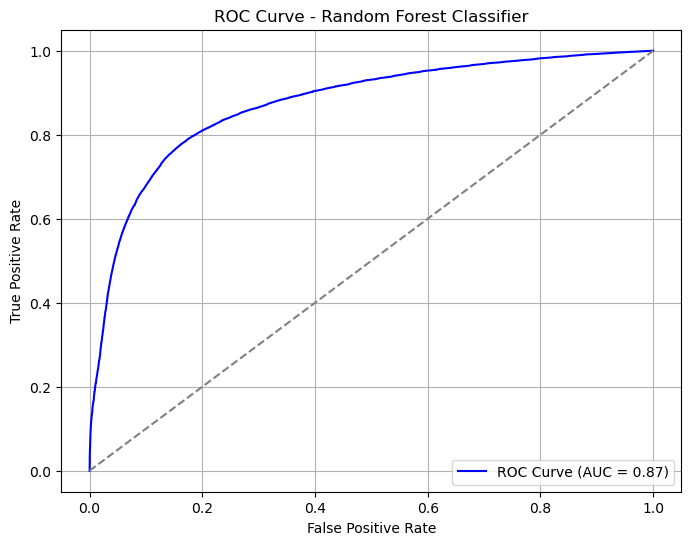

In [43]:
# Calculate AUC Curve

fpr, tpr, thresholds = roc_curve(y_test, y_probabilities_auc)

# Plot it
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Random Forest Model 2

In [37]:
# Hyperparameter Tuning

# Improve the model by tuning hyperparameters in order to reduce overfitting, increase recall and AUC as well as improve generalization. 


rf_model_tuned = RandomForestClassifier(

    n_estimators = 200,
    max_depth = 10,
    min_samples_split = 10,
    min_samples_leaf = 4,
    max_features = 'sqrt',
    random_state = 42,
    n_jobs = -1

)

rf_model_tuned.fit(X_train, y_train)




RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [38]:
y_predicitions_tuned = rf_model_tuned.predict(X_test)



In [39]:
# Evaluate the new model.

# Test accuracy gap

training_accuracy_tuned = rf_model_tuned.score(X_train, y_train)
testing_accuracy_tuned = rf_model_tuned.score(X_test, y_test)

# Test ROC AUC score

y_probabilities_auc_tuned = rf_model_tuned.predict_proba(X_test)[:,1]
auc_score_tuned = roc_auc_score(y_test, y_probabilities_auc)

# Print Evaluation metrics

print(f'Classification Report: {classification_report(y_test, y_predicitions_tuned)}')
print("----------------------------------------")
print(f"Training Accuracy: {training_accuracy_tuned:.2f}")
print(f"Testing Accuracy: {testing_accuracy_tuned:.2f}")
print("----------------------------------------")
print(f"ROC AUC Score: {auc_score_tuned :.2f}")

Classification Report:               precision    recall  f1-score   support

           0       0.69      1.00      0.82     35757
           1       0.94      0.07      0.13     17196

    accuracy                           0.70     52953
   macro avg       0.82      0.53      0.47     52953
weighted avg       0.77      0.70      0.59     52953

----------------------------------------
Training Accuracy: 0.70
Testing Accuracy: 0.70
----------------------------------------
ROC AUC Score: 0.87


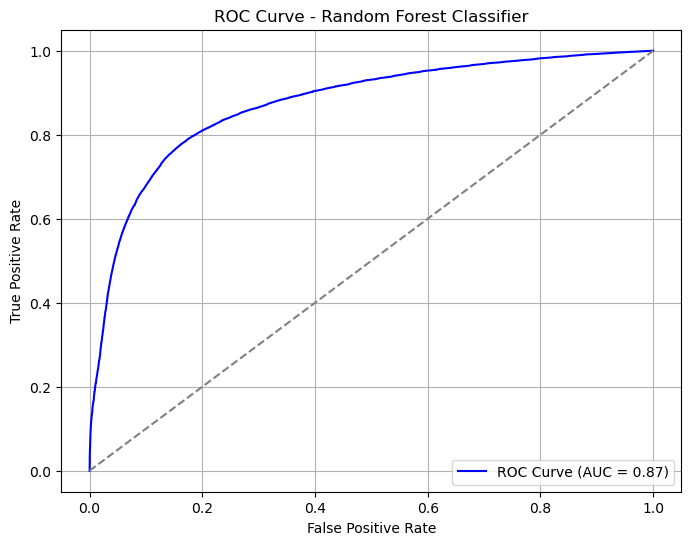

In [45]:
# Calculate AUC Curve

fpr, tpr, thresholds = roc_curve(y_test, y_probabilities_auc)

# Plot it
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score_tuned:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Random Forest Model 3

In [40]:
rf_model_tuned_2 = RandomForestClassifier(

    n_estimators = 200,
    max_depth = 18,
    min_samples_split = 5,
    min_samples_leaf = 2,
    max_features = 'sqrt',
    random_state = 42,
    n_jobs = -1

)

rf_model_tuned_2.fit(X_train, y_train)

y_predicitions_tuned_2 = rf_model_tuned_2.predict(X_test)

In [41]:
# Evaluate the new model.

# Test accuracy gap

training_accuracy_tuned_2 = rf_model_tuned_2.score(X_train, y_train)
testing_accuracy_tuned_2 = rf_model_tuned_2.score(X_test, y_test)

# Test ROC AUC score

y_probabilities_auc_tuned_2 = rf_model_tuned_2.predict_proba(X_test)[:,1]
auc_score_tuned_2 = roc_auc_score(y_test, y_probabilities_auc_tuned_2)

# Print Evaluation metrics

print(f'Classification Report: {classification_report(y_test, y_predicitions_tuned_2)}')
print("----------------------------------------")
print(f"Training Accuracy: {training_accuracy:.2f}")
print(f"Testing Accuracy: {testing_accuracy:.2f}")
print("----------------------------------------")
print(f"ROC AUC Score: {auc_score_tuned :.2f}")

Classification Report:               precision    recall  f1-score   support

           0       0.71      0.99      0.82     35757
           1       0.90      0.14      0.24     17196

    accuracy                           0.72     52953
   macro avg       0.80      0.57      0.53     52953
weighted avg       0.77      0.72      0.64     52953

----------------------------------------
Training Accuracy: 0.98
Testing Accuracy: 0.82
----------------------------------------
ROC AUC Score: 0.87


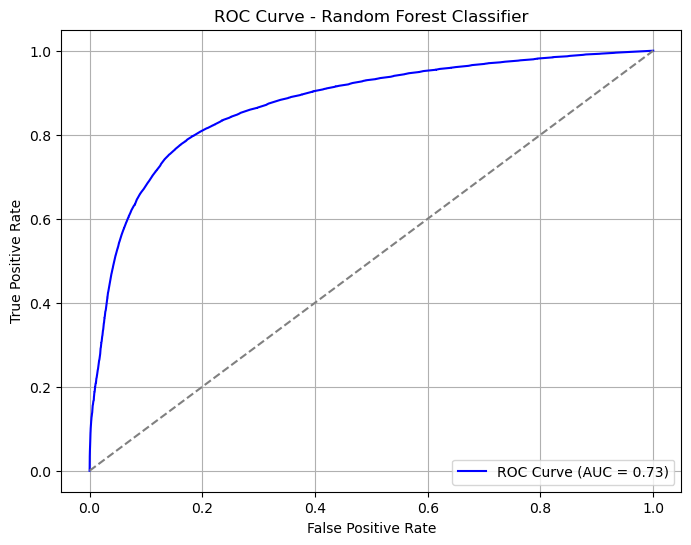

In [46]:
# Calculate AUC Curve

fpr, tpr, thresholds = roc_curve(y_test, y_probabilities_auc)

# Plot it
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score_tuned_2:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Random Forest Model 4

In [42]:
rf_model_tuned_3 = RandomForestClassifier(

    n_estimators = 300,
    max_depth = 25,
    min_samples_split = 4,
    min_samples_leaf = 1,
    max_features = 'sqrt',
    bootstrap = True,
    class_weight = 'balanced',
    random_state = 42,
    n_jobs = -1

)

rf_model_tuned_3.fit(X_train, y_train)

y_predicitions_tuned_3 = rf_model_tuned_3.predict(X_test)

# Evaluate the new model.

# Test accuracy gap

training_accuracy_tuned_3 = rf_model_tuned_3.score(X_train, y_train)
testing_accuracy_tuned_3 = rf_model_tuned_3.score(X_test, y_test)

# Test ROC AUC score

y_probabilities_auc_tuned_3 = rf_model_tuned_3.predict_proba(X_test)[:,1]
auc_score_tuned_3 = roc_auc_score(y_test, y_probabilities_auc_tuned_3)

# Print Evaluation metrics

print(f'Classification Report: {classification_report(y_test, y_predicitions_tuned_3)}')
print("----------------------------------------")
print(f"Training Accuracy: {training_accuracy:.2f}")
print(f"Testing Accuracy: {testing_accuracy:.2f}")
print("----------------------------------------")
print(f"ROC AUC Score: {auc_score_tuned_3 :.2f}")

Classification Report:               precision    recall  f1-score   support

           0       0.82      0.68      0.74     35757
           1       0.50      0.68      0.58     17196

    accuracy                           0.68     52953
   macro avg       0.66      0.68      0.66     52953
weighted avg       0.71      0.68      0.69     52953

----------------------------------------
Training Accuracy: 0.98
Testing Accuracy: 0.82
----------------------------------------
ROC AUC Score: 0.76


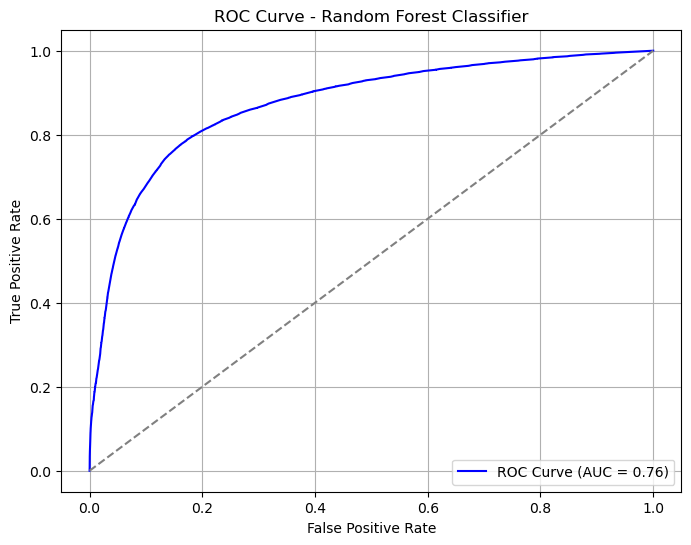

In [47]:
# Calculate AUC Curve

fpr, tpr, thresholds = roc_curve(y_test, y_probabilities_auc)

# Plot it
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score_tuned_3:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()